In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import HashingEncoder
plt.style.use('ggplot')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
df = pd.read_parquet('../data/df_cleared.parquet')

In [3]:
# Removendo coluna que representa valor target
df = df.drop('freightCost', axis=1)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4803 entries, 0 to 6775
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   weight                      4803 non-null   float64
 1   costOfGoods                 4803 non-null   float64
 2   quantity                    4803 non-null   int64  
 3   providerShippingCost        4803 non-null   float64
 4   estimatedDeliveryTimeValue  4803 non-null   int64  
 5   destination                 4803 non-null   int32  
 6   originBranchOfficeId        4803 non-null   int32  
 7   modalId                     4803 non-null   int32  
 8   fulfillmentMethod           4803 non-null   int32  
 9   productCategory             4803 non-null   int32  
 10  isPickupEnabled             4803 non-null   int32  
 11  deliveryMethodId            4803 non-null   int32  
 12  state                       4803 non-null   int32  
 13  shippingMethod              4803 non-n

In [5]:
all_cols = df.columns
num_cols = ['weight', 'costOfGoods','quantity', 'providerShippingCost','estimatedDeliveryTimeValue']
cat_cols = [col for col in all_cols if col not in num_cols]

In [6]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

Target Encoder para as variáveis categóricas

In [104]:
from sklearn.preprocessing import TargetEncoder


target = 'providerShippingCost'
encoder = TargetEncoder(target_type = 'continuous', random_state= 42, cv=5)
encoded_values = encoder.fit_transform(X= train_df[cat_cols], y= train_df[target])

df_encoded_cols = pd.DataFrame(encoded_values, columns=cat_cols).reset_index(drop=True)

train_df_encoded = train_df.copy().drop(cat_cols, axis=1).reset_index(drop=True)
train_df_encoded = pd.concat([train_df_encoded, df_encoded_cols], axis=1)


encoded_values = encoder.transform(X= test_df[cat_cols])
df_encoded_test = pd.DataFrame(encoded_values, columns=cat_cols)
test_df_encoded = test_df.copy().drop(cat_cols, axis=1).reset_index(drop=True)
test_df_encoded = pd.concat([test_df_encoded, df_encoded_test], axis=1)

In [105]:
from sklearn.ensemble import RandomForestRegressor as RFR, AdaBoostRegressor as ABR, GradientBoostingRegressor as GBR
from catboost import CatBoostRegressor as CB
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, root_mean_squared_error as rmse, \
mean_squared_log_error as msle, r2_score as r2, mean_absolute_percentage_error as mape
import numpy as np

def train_model(train_df: pd.DataFrame, test_df: pd.DataFrame)->pd.DataFrame:

    X_train = train_df.drop("providerShippingCost", axis=1)
    y_train = train_df['providerShippingCost']

    X_test = test_df.drop("providerShippingCost", axis=1)
    y_test = test_df['providerShippingCost']
    dict_result = {'Regressor': [],'MAE': [],'MAPE': [],'RMSE': [],'RMSLE': [],'Rsquared': []}

    for regressor in [
        GBR(random_state=42, n_estimators=500, learning_rate=0.1),
        ABR(random_state=42, n_estimators=500, learning_rate=0.1), 
        CB(random_state=42,depth= 4, iterations= 500, l2_leaf_reg= 1, learning_rate= 0.3, verbose=0)
        ]:
        model = regressor.fit(X=X_train, y = y_train)
        y_pred = model.predict(X_test)
        y_pred = np.clip(y_pred, a_min=0.01, a_max=None)
        mse_score = mse(y_true=y_test, y_pred = y_pred)
        mae_score = mae(y_true=y_test, y_pred = y_pred)
        mape_score = mape(y_true=y_test, y_pred = y_pred)
        rmse_score = rmse(y_true=y_test, y_pred = y_pred)
        rmsle_score = np.sqrt(msle(y_true=y_test, y_pred = y_pred))
        rsqrt = r2(y_test, y_pred)
        dict_result['Regressor'].append(str(regressor.__class__).split('.')[-1].split("'")[0])
        dict_result['MAE'].append(mae_score)
        dict_result['MAPE'].append(mape_score)
        dict_result['RMSE'].append(rmse_score)
        dict_result['RMSLE'].append(rmsle_score)
        dict_result['Rsquared'].append(rsqrt)
    result = pd.DataFrame(dict_result)

    importances = model.feature_importances_
    importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances})

    display(result)
    return result, importances_df

Treinar e testar modelo com as variáveis categóricas codificado (encodered)

In [106]:
result, imp = train_model(train_df_encoded, test_df_encoded)

,Regressor,MAE,MAPE,RMSE,RMSLE,Rsquared
0,GradientBoostingRegressor,1.180820,1.122729,8.001095,0.127618,0.985162
1,AdaBoostRegressor,5.079307,9.389359,7.629896,0.493817,0.986507
2,CatBoostRegressor,1.423230,0.893666,6.976821,0.136491,0.988718


Treinar modelo com dados sem encoder

In [107]:
result, imp = train_model(train_df, test_df)

,Regressor,MAE,MAPE,RMSE,RMSLE,Rsquared
0,GradientBoostingRegressor,0.932291,1.209139,5.059860,0.120337,0.994066
1,AdaBoostRegressor,6.373539,9.599834,9.708187,0.572919,0.978156
2,CatBoostRegressor,0.734359,0.194331,4.104427,0.086795,0.996095


Modelo CatBoost obteve menor erro em todas as métricas. Além disso foi mostrado que o encoder na verdade prejudicou a performance dos modelos em todos os casos.

In [12]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor as CB

catboost_model = CB(silent=True)

param_grid = {
    'n_estimators': [100, 200, 300, 500],                
    'learning_rate': [ 0.1, 0.5, 0.05],     
    'l2_leaf_reg': [1, 2, 5, None]       
}

grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=5)

X_train = train_df.drop('providerShippingCost',axis=1)
y_train = train_df['providerShippingCost']

X_test = test_df.drop('providerShippingCost',axis=1)
y_test = test_df['providerShippingCost']

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Best parameters found:  {'l2_leaf_reg': 1, 'learning_rate': 0.5, 'n_estimators': 500}
Best cross-validation score:  0.9894973412933986


In [16]:
grid_search.best_params_

{'l2_leaf_reg': 1, 'learning_rate': 0.5, 'n_estimators': 500}

In [20]:
# Salvando os parametros para serem utilizados depois
best_params = grid_search.best_params_

Após o resultado do grid de melhores parâmetros podemos treinar novamente somente o *catboost* e testar com o set de validação e utilizar apenas **5 amostras aleatórias** destes set segundo as regras do desafio proposto.

In [72]:
from catboost import CatBoostRegressor as CB
from typing import Dict

def train_model_validation(train_df: pd.DataFrame, 
                    val_df: pd.DataFrame,
                    best_params:Dict, 
                    )->pd.DataFrame:

    X_train = train_df.drop("providerShippingCost", axis=1)
    y_train = train_df['providerShippingCost']

    val_df = val_df.sample(50, random_state=42)
    X_val = val_df.drop("providerShippingCost", axis=1)
    y_val = val_df['providerShippingCost']
    dict_result = {'Regressor': [],'MAE': [],'MAPE': [],'RMSE': [],'RMSLE': [],'Rsquared': []}

    regressor = CB(**best_params, verbose=False)
    model = regressor.fit(X=X_train, y = y_train)
    y_pred = model.predict(X_val)
    y_pred = np.clip(y_pred, a_min=0.01, a_max=None)
    mae_score = mae(y_true=y_val, y_pred = y_pred)
    mape_score = mape(y_true=y_val, y_pred = y_pred)
    rmse_score = rmse(y_true=y_val, y_pred = y_pred)
    rmsle_score = np.sqrt(msle(y_true=y_val, y_pred = y_pred))
    rsqrt = r2(y_val, y_pred)
    dict_result['Regressor'].append(str(regressor.__class__).split('.')[-1].split("'")[0])
    dict_result['MAE'].append(mae_score)
    dict_result['MAPE'].append(mape_score)
    dict_result['RMSE'].append(rmse_score)
    dict_result['RMSLE'].append(rmsle_score)
    dict_result['Rsquared'].append(rsqrt)
    result = pd.DataFrame(dict_result)

    importances = model.feature_importances_
    importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances})

    display(result)
    return result, y_pred, y_val, X_val, importances_df

In [79]:
result, y_pred, y_val, X_val, importances_df = train_model_validation(train_df=train_df, 
                                                                                      val_df=val_df, 
                                                                                      best_params= best_params)

,Regressor,MAE,MAPE,RMSE,RMSLE,Rsquared
0,CatBoostRegressor,0.303153,0.026554,0.901272,0.064051,0.995747


In [80]:
importances_df.sort_values('Importance', ascending=False)

,Feature,Importance
0,weight,94.577312
17,idShop,1.495542
4,destination,1.463338
3,estimatedDeliveryTimeValue,0.753494
6,modalId,0.573649
11,state,0.278524
12,shippingMethod,0.262330
1,costOfGoods,0.176121
10,deliveryMethodId,0.157735
13,origin,0.065430


In [81]:
df_val = pd.DataFrame({'y_pred':y_pred,
                       'y_real': y_val,
                       'residual': y_val - y_pred
                       })

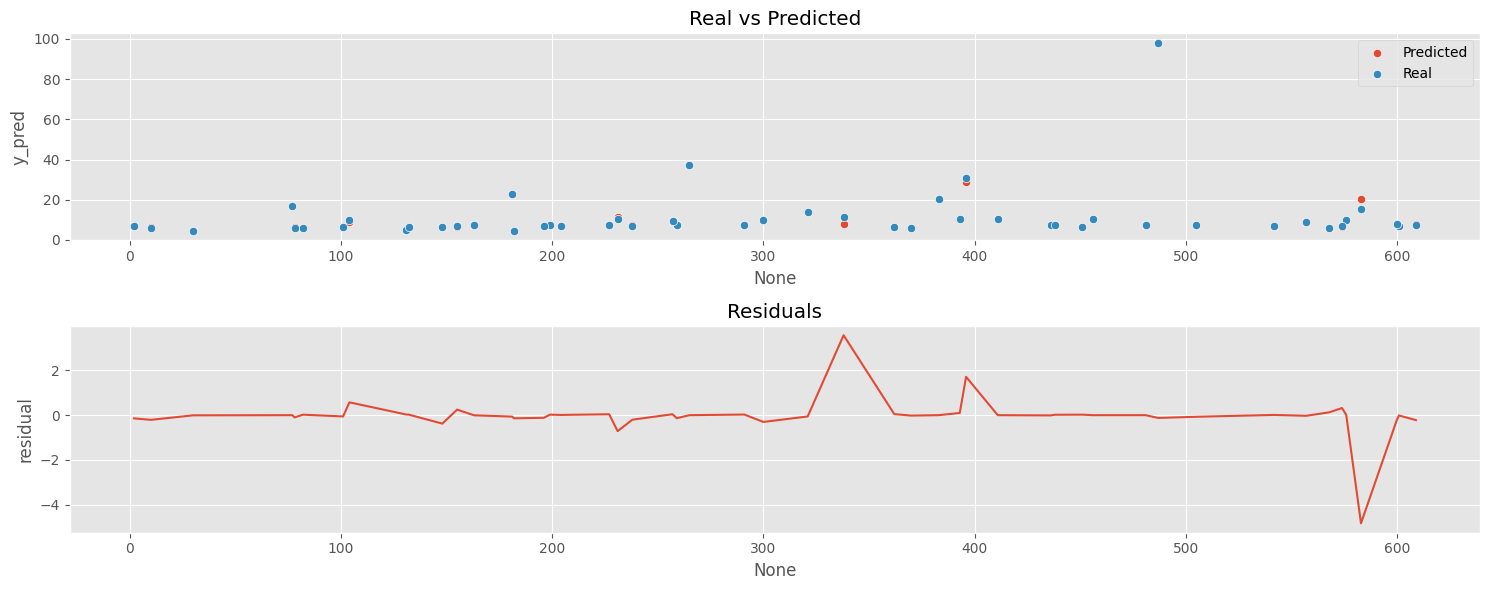

In [83]:
# Create a figure with subplots
plt.figure(figsize=(15, 6))

# First subplot for real and predicted values
plt.subplot(2, 1, 1)  # 2 rows, 1 column, plot 1
sns.scatterplot(data=df_val, x=df_val.index, y='y_pred', label='Predicted')
sns.scatterplot(data=df_val, x=df_val.index, y='y_real', label='Real')
plt.title('Real vs Predicted')
plt.legend()

# Second subplot for residuals
plt.subplot(2, 1, 2)  # 2 rows, 1 column, plot 2
sns.lineplot(x=df_val.index, y=df_val['residual'])
plt.title('Residuals')

# Show the plot
plt.tight_layout()
plt.show()